# Pyomo.DAE Example: Race Car

Adapted from [](./PyomoDAE_example.ipynb) and https://github.com/Pyomo/pyomo/blob/master/examples/dae/car_example.py

## Introduction and Learning Objectives

This notebook:
* Introduces syntax for Pyomo.DAE
* Shows time-scaling modeling trick
* Pratice using [units](https://pyomo.readthedocs.io/en/stable/advanced_topics/units_container.html) feature in Pyomo

## Install Packages and Load Modules

In [13]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

In [14]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pyomo.dae as dae
from pyomo.environ import units

## Problem Statement and Optimal Control Formulation

You are a race car driver with a simple goal. Drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.

Mathematically, you want to solve the following optimal control problem:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

where $a$ is the acceleration/braking (your control variable) and $R$ is the drag coefficient (parameter).

### Scale Time

Let $t = \tau \cdot t_f$ where $\tau \in [0,1]$. Thus $dt = t_f d\tau$. The optimal control problem becomes:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{d\tau} = t_f v \\
& \frac{dv}{d\tau} = t_f (u - R v^2) \\
& x(\tau = 0) = 0, ~~ x(\tau = 1) = L \\
& v(\tau = 0) = 0, ~~ v(\tau = 1) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

### Declaring our Model with Pyomo.DAE

We can use `Pyomo.dae` to automatically formulate the collocation equations (i.e., add constraints that numerically integrate the ODE model).

In [15]:
# Define the  model
m = pyo.ConcreteModel()

# Deine the model parameters
m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Friction factor
m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position

# Define time
m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

# Define remaining algebraic variables
m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
m.u = pyo.Var(m.tau, bounds=(-3.0,1.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

# Define derivative variables
m.dx = dae.DerivativeVar(m.x)
m.dv = dae.DerivativeVar(m.v)

# Declare the objective (minimize final time)
m.obj = pyo.Objective(expr=m.tf)

# Define the constraints
# position
def _ode1(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

# velocity
def _ode2(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

# Define the inital/boundary conditions
def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    
m.initcon = pyo.ConstraintList(rule=_init)

Now let's inspect the model.

In [16]:
m.pprint()

2 Param Declarations
    L : Size=1, Index=None, Domain=Any, Default=None, Mutable=True, Units=m
        Key  : Value
        None : 100.0
    R : Size=1, Index=None, Domain=Any, Default=None, Mutable=True, Units=1/m
        Key  : Value
        None : 0.001

4 Var Declarations
    tf : Size=1, Index=None, Units=s
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    u : Size=2, Index=tau, Units=m/s**2
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  -3.0 :     0 :   1.0 : False : False :  Reals
          1 :  -3.0 :     0 :   1.0 : False : False :  Reals
    v : Size=2, Index=tau, Units=m/s
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :  None : False :  True :  Reals
          1 :     0 :  None :  None : False :  True :  Reals
    x : Size=2, Index=tau, Units=m
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :

### Discretize/Transcribe and Solve

In [17]:
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m,nfe=15,scheme='BACKWARD')

# Declare the discretizer
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-RADAU',ncp=3)
#discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-LEGENDRE',ncp=3)

# force piecewise constant controls (acceleration) over each finite element
m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

# Solve
solver = pyo.SolverFactory('ipopt')
solver.solve(m,tee=True)

print("final time = %6.2f seconds" %(pyo.value(m.tf)))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

### Plot Results

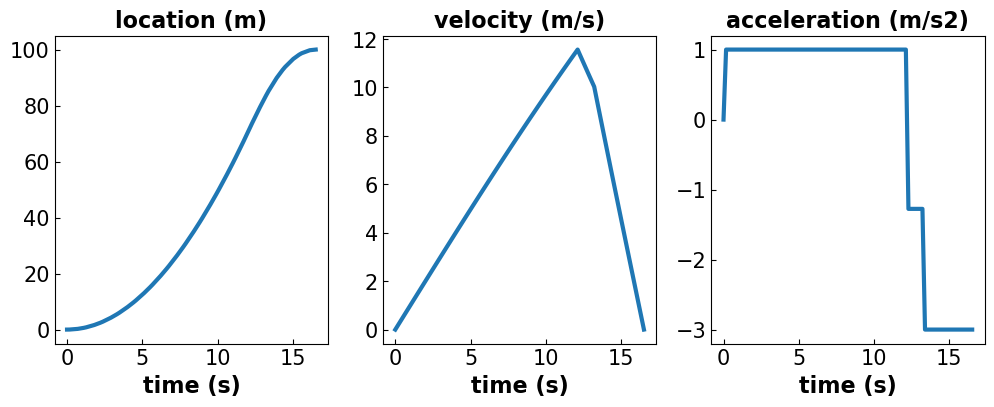

In [18]:
# Define empty lists
x = []    # position, units of length
v = []    # velocity, units of length per time
u = []    # acceleration, units of length per time squared
time=[]   # time
tf = pyo.value(m.tf)

# Loop over time and append the solution values for each variable to their respective lists
for i in m.tau:
    time.append(i*tf)
    x.append(pyo.value(m.x[i]))
    v.append(pyo.value(m.v[i]))
    u.append(pyo.value(m.u[i]))

# Make a figure
plt.figure(figsize=(12,4))

# Format subplot 1 (position)    
plt.subplot(131)
plt.plot(time,x,linewidth=3,label='x')
plt.title('location (m)',fontsize=16, fontweight='bold')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

# Format subplot 2 (velocity)
plt.subplot(132)
plt.plot(time,v,linewidth=3,label='v')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.title('velocity (m/s)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

# Format subplot 3 (acceleration)
plt.subplot(133)
plt.plot(time,u,linewidth=3,label='a')
plt.xlabel('time (s)',fontsize=16, fontweight='bold')
plt.title('acceleration (m/s2)',fontsize=16, fontweight='bold')
plt.tick_params(direction="in",labelsize=15)

plt.show()

**Discussion Questions**

Do the results make sense?

What do you know about the relationships between position, velocity, and acceleration? Do you see this relationship in the plots?

## Another Version

Antoher modeling option to to define an extra differential equation to compute time.

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{d\tau} = t_f v \\
& \frac{dv}{d\tau} = t_f (u - R v^2) \\
& \frac{dt}{d\tau} = t_f \\
& x(\tau = 0) = 0, ~~ x(\tau = 1) = L \\
& v(\tau = 0) = 0, ~~ v(\tau = 1) = 0 \\
& t(\tau = 0) = 0 \\
& -3 \leq u \leq 1
\end{align*}$$

In [19]:
# Define the  model
m = pyo.ConcreteModel()

# Define the  model
m = pyo.ConcreteModel()

# Deine the model parameters
m.R = pyo.Param(initialize=0.001, units=1/units.m) # Friction factor
m.L = pyo.Param(initialize=100.0, units=units.m) # Final position

# Define time
m.tau = dae.ContinuousSet(bounds=(0,1))                 # Dimensionless time set
m.time = pyo.Var(m.tau, bounds=(0,None), units=units.s) # Time
m.tf = pyo.Var(initialize=1, units=units.s)             # Final time

# Define remaining algebraic variables
m.x = pyo.Var(m.tau, bounds=(0,m.L + 50*units.m), units=units.m)                    # Position
m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
m.u = pyo.Var(m.tau, bounds=(-3.0,1.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

# Define derivative variables
m.dtime = dae.DerivativeVar(m.time)
m.dx = dae.DerivativeVar(m.x)
m.dv = dae.DerivativeVar(m.v)

# Declare the objective (minimize final time)
m.obj = pyo.Objective(expr=m.tf)

# Define the constraints
# position
def _ode1(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

# velocity
def _ode2(m,i):
    if i == 0 :
        return pyo.Constraint.Skip
    return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

# time
def _ode3(m,i):
    if i == 0:
        return pyo.Constraint.Skip
    return m.dtime[i] == m.tf
m.ode3 = pyo.Constraint(m.tau, rule=_ode3)

# Define the inital/boundary conditions
def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    yield m.time[0] == 0
    
m.initcon = pyo.ConstraintList(rule=_init)

In [20]:
# Declare the discretizer
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-RADAU',ncp=3)

# force piecewise constant controls (acceleration) over each finite element
m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

# Solve
solver = pyo.SolverFactory('ipopt')
solver.solve(m,tee=True)

print("final time = %6.2f seconds" %(pyo.value(m.tf)))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://